# Plank Filter

## Imports

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import (
    Compose,
    Normalize,
    Resize,
    ToPILImage,
    ToTensor,
    PILToTensor,
)
import torchvision


## Load Data

In [13]:
class plankFilterDataset(Dataset):
    def __init__(
        self, annotations_file, img_dir, transform=None, target_transform=None
    ):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


In [14]:
# Transform to convert a PIL image to a tensor
img_pipeline = Compose(
    [
        ToPILImage(),
        Resize((224, 224)),
        ToTensor(),
    ]
)

ds = plankFilterDataset(
    annotations_file=os.path.join("data", "filter_plank_labels.csv"),
    img_dir=os.path.join("subset", "filter_plank"),
    transform=img_pipeline,
)
batch_size = 8
validation_split = 0.2
shuffle_dataset = True
random_seed = 42


In [15]:
# Creating data indices for training and validation splits
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(ds, [train_size, test_size])

In [16]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

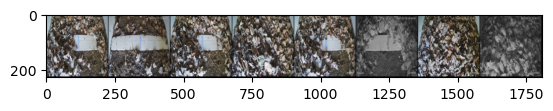

1 1 1 0 1 1 0 0


In [17]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
batch = iter(train_loader)
images, labels = next(batch)


# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(" ".join(f"{l}" for l in labels))


In [18]:
""" from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler


# Creating data indices for training and validation splits:
dataset_size = len(ds)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(
    ds, batch_size=batch_size, sampler=train_sampler
)
validation_loader = torch.utils.data.DataLoader(
    ds, batch_size=batch_size, sampler=valid_sampler
)
 """

' from torch.utils.data import DataLoader\nfrom torch.utils.data.sampler import SubsetRandomSampler\n\n\n# Creating data indices for training and validation splits:\ndataset_size = len(ds)\nindices = list(range(dataset_size))\nsplit = int(np.floor(validation_split * dataset_size))\nif shuffle_dataset:\n    np.random.seed(random_seed)\n    np.random.shuffle(indices)\ntrain_indices, val_indices = indices[split:], indices[:split]\n\n# Creating PT data samplers and loaders:\ntrain_sampler = SubsetRandomSampler(train_indices)\nvalid_sampler = SubsetRandomSampler(val_indices)\n\ntrain_loader = torch.utils.data.DataLoader(\n    ds, batch_size=batch_size, sampler=train_sampler\n)\nvalidation_loader = torch.utils.data.DataLoader(\n    ds, batch_size=batch_size, sampler=valid_sampler\n)\n '

## Build The Neural Network

We define a convolutionnal neural network with 3 convolutionnal layers and 2 fully connected layers. The output is two neurons who tells wheter there is a plank or not.


In [19]:
class PlankFilter(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.fc1 = nn.Linear(in_features=128 * 30 * 30, out_features=128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.reshape(-1, 128 * 30 * 30)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.sigmoid(x)

## Define a Loss function and optimizer

In [20]:
# Hyperparameters
hp = dict(num_epochs=2, learning_rate=0.001, momentum=0.9)


In [21]:
net = PlankFilter()
loss_fn = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=hp['learning_rate'], momentum=hp['momentum'])

## Zero the gradients while training the network


In [22]:
for epoch in range(hp["num_epochs"]):  # loop over the dataset multiple times

    running_loss = 0.0

    for n_batch, (inputs, labels) in enumerate(train_loader, start=1):
        # get the inputs; data is a list of [inputs, labels]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        labels = labels.to(torch.float32).reshape(-1, 1)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics every 2000 mini-batches
        running_loss += loss.item()
        if n_batch % 2000 == 1999: 
            print(
                "[%d, %5d] loss: %.3f" % (epoch + 1, n_batch + 1, running_loss / 2000)
            )
            running_loss = 0.0

print("Finished Training")


RuntimeError: shape '[-1, 115200]' is invalid for input of size 692224